# CNN model

This notebook trains a convolutional layer over the input probability distributions.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.data as udata
import utils.dists as udists
import utils.misc as u
import os
import losses

from functools import partial
from jrun import jin
from keras.layers import (Activation, Convolution1D, Convolution2D, Dense,
                          Dropout, Embedding, Flatten, Merge, Input)
from keras.layers.merge import Concatenate, concatenate
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
import keras.backend as K

Using Theano backend.


## Setup notebook parameters

In [28]:
EXP_NAME = jin("exp", "cnn/seasons-4-to-3")
COMPONENTS = jin("components", u.available_models("../data"))
WEEK_NUMBER = jin("week", 1)
TEST_SPLIT_THRESH = jin("splitweek", 201443)

## Load data

In [29]:
class Component:
    """
    Helper class for working with components
    """
    
    def __init__(self, name):
        self.name = name
        self.loader = udata.ComponentDataLoader("../data", name)

In [30]:
components = [Component(name) for name in COMPONENTS]
actual_dl = udata.ActualDataLoader("../data")

### Working on week ahead predictions

We need to take the common row entries (common "epiweek", "region") for each data item, i.e. actual data and component data.

In [31]:
REGION = None # Specify None for using all the data

y, Xs, yi = udata.get_week_ahead_training_data(
    WEEK_NUMBER, REGION,
    actual_dl, [cmp.loader for cmp in components]
)

for idx, cmp in enumerate(components):
    cmp.data = Xs[idx]

### Creating input matrices for model

In [32]:
X = udists.get_2d_features(Xs)
y = udists.actual_to_one_hot(y)

### Split based on year
We take items before a certain epiweek as train and rest as test

In [33]:
train_indices = yi[:, 0] < TEST_SPLIT_THRESH

## Model

In [34]:
def conv1D_distribution(n_components, n_bins):
    """
    One dimensional conv model over input distribution to give an output
    distribution

    Parameters
    ----------
    n_components : int
        Number of component distributions
    n_bins : int
        Number of bins in the prediction distribution
    """

    dist_input = Input(shape=(n_bins, n_components))
    dist_x = Convolution1D(32, 5, padding="same")(dist_input)
    dist_x = Convolution1D(10, 3, padding="same")(dist_x)
    dist_x = Flatten()(dist_x)
    dist_x = Dense(10, activation="tanh")(dist_x)
    dist_x = Dense(n_bins, activation="softmax")(dist_x)
    
    model = Model(inputs=dist_input, outputs=dist_x)

    return model

### Training

In [35]:
# model generator
def gen_model():
    return conv1D_distribution(X.shape[-1], X.shape[1])

def train_model(
    model, train_data, val_data,
    batch_size=64, epochs=100,
    verbose=0
):
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

    if val_data is not None:
        callbacks = [EarlyStopping(monitor="val_loss", patience=4, mode="auto")]
    else:
        callbacks = []

    history = model.fit(train_data[0],
                        train_data[1],
                        batch_size=batch_size, epochs=epochs,
                        verbose=verbose,
                        callbacks=callbacks,
                        validation_data=val_data)
    return history

  0%|          | 0/4 [00:00<?, ?it/s]

[2010, 2011, 2012, 2013]


100%|██████████| 4/4 [07:55<00:00, 119.21s/it]


[{'val_loss': [4.5786773941733623, 4.4001157376673312, 4.2597048189732938, 4.1572430722125162, 4.0636316150813911, 3.9849037195180919, 3.9169972531207198, 3.849988280952751, 3.7920378957475935, 3.7426319308095164, 3.7000334448628611, 3.6570336478097096, 3.6126967219563273, 3.5822258986435926, 3.5460179502313789, 3.5172468098727139, 3.4908637659890309, 3.4594992445660875, 3.4407303519063182, 3.4128839721927395, 3.3957379173922848, 3.3764030561818705, 3.3579094657650241, 3.3372603918050792, 3.3205727044638103, 3.2997333074544932, 3.2827861463868775, 3.2696910399895209, 3.2560157218536774, 3.2485243407162754, 3.2367527546820702, 3.2281244915801208, 3.2149258588815663, 3.2002767959198395, 3.1972526946625153, 3.1785163414942752, 3.1780031965924547, 3.1579661121616116, 3.148211045698686, 3.1390968762434923, 3.1376139777047292, 3.140043577590546, 3.1282771067185835, 3.1192334565249356, 3.1044098835486871, 3.1108250277382985, 3.1067921867618313, 3.0957113984343292, 3.0964610607593093, 3.080456

,epochs,train_loss,val_loss
it-1,82.0,2.580091,3.004651
it-2,76.0,2.760310,2.760831
it-3,76.0,2.623485,3.227897
it-4,76.0,2.653660,2.976682
mean,77.5,2.654386,2.992515


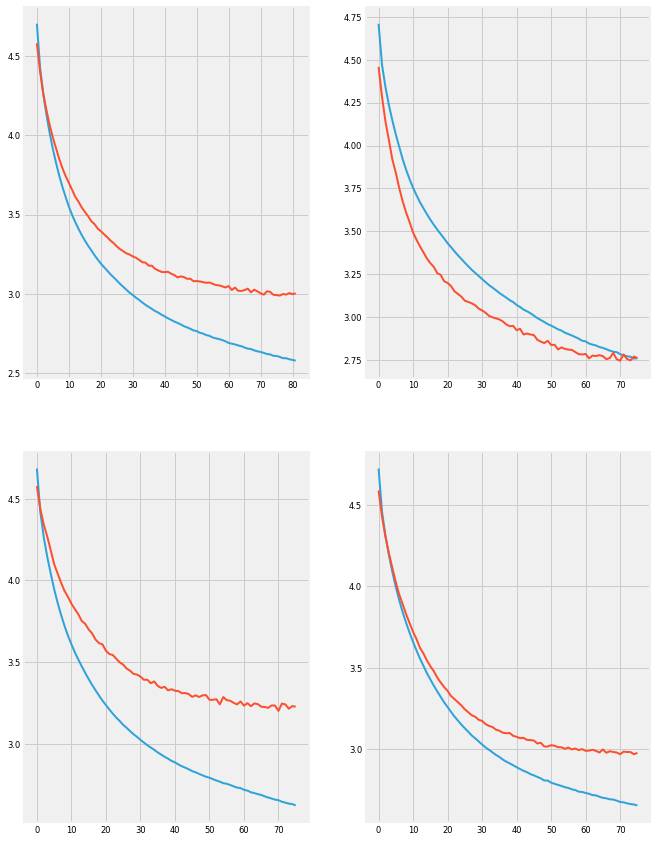

In [36]:
cv_metadata = u.cv_train_loso(
    gen_model, train_model,
    X[train_indices], y[train_indices], yi[train_indices]
)
u.cv_plot(cv_metadata)
cv_report = u.cv_report(cv_metadata)
cv_report

### Final model training

2.6410697156732734

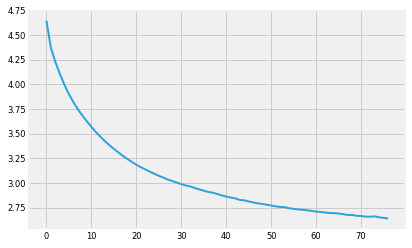

In [37]:
model = gen_model()
final_epochs = int(cv_report["epochs"][-1])
final_history = train_model(
    model,
    (X[train_indices], y[train_indices]),
    None, epochs=final_epochs)
final_loss = final_history.history["loss"][-1]
plt.plot(final_history.history["loss"])
final_loss

### Evaluation

In [38]:
regions = ["nat", *[f"hhs{i}" for i in range(1, 11)], None]

mdls = [*[cmp.name for cmp in components], "n-ensemble",
        "ave-ensemble", "prod-ensemble"]

eval_df = {mdl: [] for mdl in mdls}

for region in regions:
    if region is None:
        eval_indices = ~train_indices
    else:
        eval_indices = (~train_indices) & (yi[:, 1] == region)
        
    component_dists = [cmp.data[eval_indices] for cmp in components]
    n_dist = model.predict(X[eval_indices])
    
    dists = [
        *component_dists,
        n_dist,
        udists.mean_ensemble(component_dists),
        udists.prod_ensemble(component_dists)
    ]
    
    for name, output in zip(mdls, dists):
        eval_df[name].append(losses.mean_cat_cross(y[eval_indices], output))
eval_df = pd.DataFrame(eval_df)
eval_df.index = [*regions[:-1], "all"]
eval_df = eval_df[mdls]

# Save results
output_dir = u.ensure_dir(f"../results/{EXP_NAME}")
u.save_exp_summary(model, cv_report, {
    "loss": final_loss,
    "epochs": final_epochs
}, f"{output_dir}/{WEEK_NUMBER}_summary.txt")
eval_df.to_csv(f"{output_dir}/{WEEK_NUMBER}_eval.csv")
eval_df

,Delphi-DeltaDensity2,CU-BMA,CU-EAKFC,ReichLab-KDE,ReichLab-SARIMA1,Delphi-BasisRegression,Delphi-DeltaDensity1,Delphi-Uniform,ReichLab-SARIMA2,Delphi-Stat,Delphi-EmpiricalBayes1,Delphi-EmpiricalFuture,Delphi-EmpiricalBayes2,ReichLab-KCDE,Delphi-EmpiricalTraj,n-ensemble,ave-ensemble,prod-ensemble
nat,2.9172301000817993,3.0924747885978845,3.1750303411169565,3.3592908267530017,2.446762851443709,4.607136019879603,2.3460068114617707,4.894790513792236,2.5937314334391397,2.376672478150014,3.9250515438564535,3.6351014919562994,4.807430612086085,2.512254941658262,3.6351014919562994,2.8866182210899534,2.704388748567023,5.893447730777097
hhs1,3.004511792849231,2.846385938585456,2.6436674370421267,3.4408460663619826,2.688458490047876,4.636153317831431,2.639357533922921,5.006645623298791,2.7397705871198914,2.5259171584094693,2.8628238045462475,3.494709248758831,4.138908545977188,2.4544398362422326,3.494709248758831,2.4350724929854985,2.713512676526439,5.898682817466191
hhs2,5.73167482026675,3.838345360584777,5.25101798317009,4.025539540691924,3.426291238646065,4.605287703921759,4.157506681910428,4.855773203071671,3.524983550528297,3.585100725495031,4.379757875960487,4.0276257580621495,5.53387309733378,3.57711498456535,4.0276257580621495,3.5059115333216533,3.5068160818011904,5.511371544052245
hhs3,3.4720041424702734,3.477309155525151,4.436004275557739,3.4675959972334787,3.01431965519807,4.62011414981991,3.044521143449319,4.908292512671959,3.182864246677274,2.8908537076109493,3.7205859824289345,3.749451484690636,4.207660457022589,2.923390355386958,3.749451484690636,2.9602966138294766,3.142547978833343,5.720369891281107
hhs4,3.719766302580501,3.353815041876879,3.811717863993368,3.7583684902193646,2.7421854625568494,4.623898471908979,3.1475550363623377,4.913631535064361,2.8130870093624525,2.8704388805817973,4.425114392697583,3.9902621598950114,6.074990282579604,3.1471388670864773,3.9902621598950114,2.9384958289918446,3.016116280086546,5.7553412740870655
hhs5,3.03939041721649,3.2067380031924544,3.2853248675616578,3.430141263202331,2.543092516105258,4.634113925512855,2.631067893130961,4.9604333789652175,2.5741988885375875,2.4584659237444297,4.35314800569539,3.5781800735525824,5.587054091440448,2.665407120292931,3.5781800735525824,2.70139664269629,2.754281109846456,5.848477815081465
hhs6,3.950008473944277,4.132221954598985,4.7736672895414545,4.533390502879348,3.7206815747586885,4.605269921169854,3.3874649570879427,4.797076906686364,3.8404389938179806,3.375987934399087,4.335304988577808,4.216691976261633,5.923385057321323,3.4134156634023523,4.216691976261633,3.7395122079622176,3.6375089313314226,5.460777699580302
hhs7,3.4489431806364825,3.6270292475308756,3.8794177567938446,3.5539127003637465,2.9321427707771255,4.643976789412741,2.998231102982877,4.97438603331607,2.9943543254255003,2.879461060846679,4.19534197462997,3.7122869327950205,5.245364325792666,2.8972634001365116,3.7122869327950205,2.978430932476407,3.0826469155253813,5.7310574840535775
hhs8,3.095386201874264,2.863677190917463,2.9787519788786843,3.314909476867549,2.7608600253307025,4.649900511165918,2.472620132160532,5.030641218052099,2.8398497339192863,2.4665421975265813,2.6783579366622723,3.3606026148036237,3.1300493608118427,2.5961086186111135,3.3606026148036237,2.4632621705532074,2.7088375929176665,5.899046587469609
hhs9,3.941953889897764,3.5023816155447585,3.8651965052233224,3.5607168380057264,3.2010539873115897,4.604119647964435,3.039206320107971,4.885715031993941,3.1722325274383687,3.0116410812361356,3.401140189290779,3.574023450725131,4.464254921137548,2.928411404495412,3.574023450725131,3.0155257951645624,3.1210615849066943,5.7249513817525655


## Plot random predictions

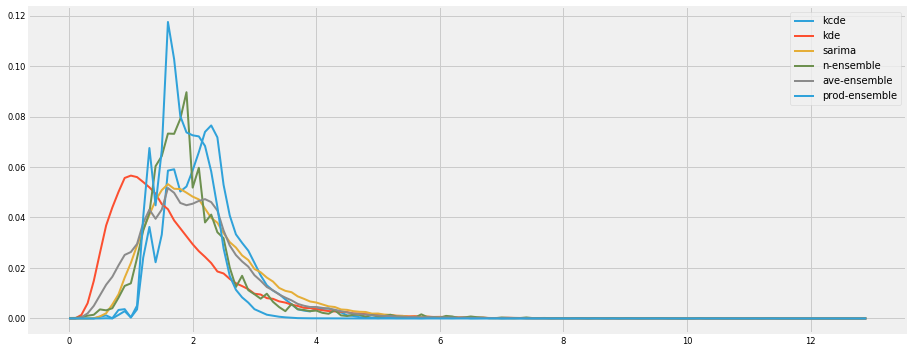

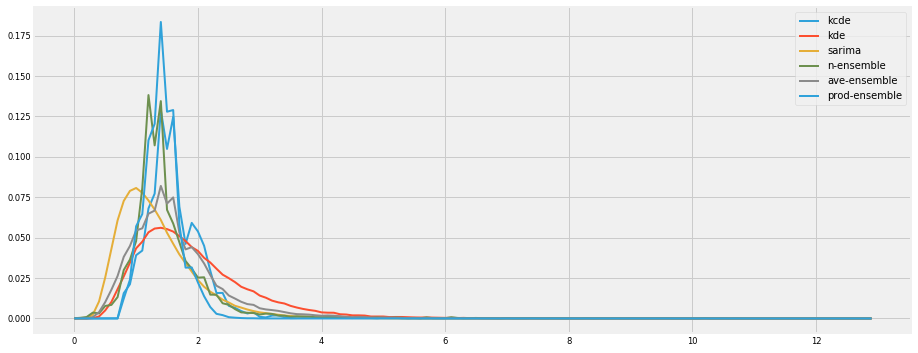

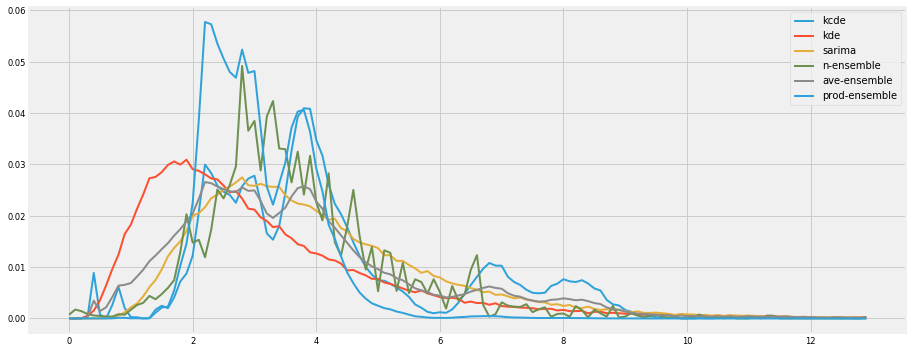

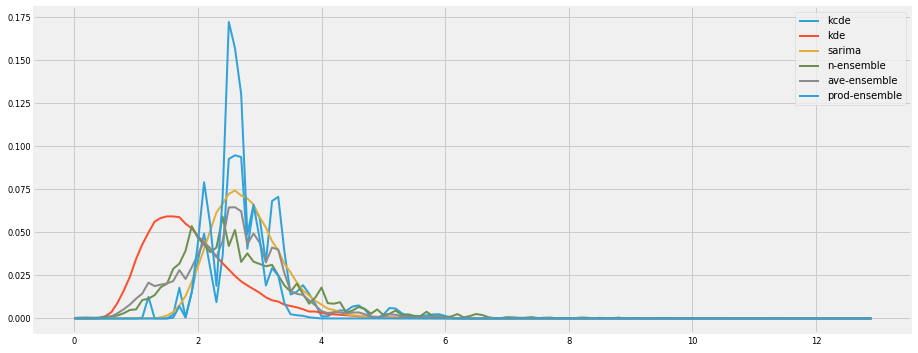

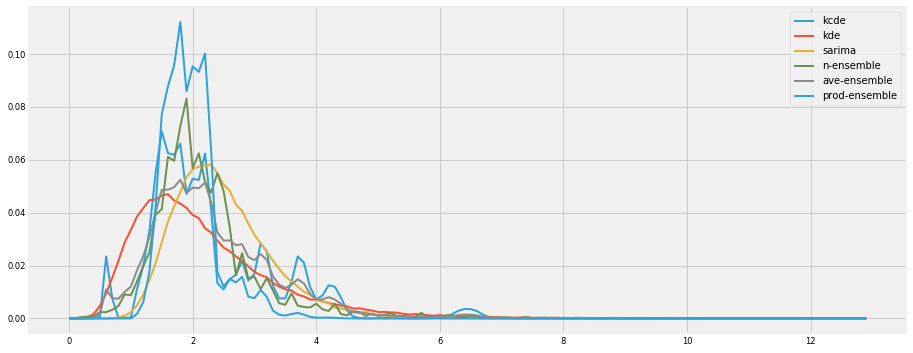

In [43]:
# Sample few of the examples
n_plots = 5
plot_indices = np.random.randint(0, y[~train_indices].shape[0], size=n_plots)

# y_plot_out = y[~train_indices][plot_indices]

component_dists = [cmp.data[~train_indices][plot_indices] for cmp in components]
n_dist = model.predict(X[~train_indices][plot_indices])

dists = [
    *component_dists,
    n_dist,
    udists.mean_ensemble(component_dists),
    udists.prod_ensemble(component_dists)
]

bins = udists.BINS["wili"]
mdls = [*[cmp.name for cmp in components], "n-ensemble", "ave-ensemble", "prod-ensemble"]

for pidx in range(n_plots):
    plt.figure(figsize=(14, 6))
    for idx, mdl in enumerate(mdls):
        plt.plot(bins, dists[idx][pidx], label=mdl)
    
    # Plot actual line
#     plt.axvline(x=y_plot_out[pidx])
    
    plt.legend()